# Ensemble Folds with MEDIAN - [0.153]
This notebook is a fork of [Zhangxin's][1] notebook [here][2]. The purpose of this notebook is to demonstrate using **median** (instead of mean) to ensemble fold model predictions. Additionally it demonstrates "rounding" predictions to match the discrete target distribution observed in train data.

Since the [competition metric][3] is MAE, using **median** is best. If the competition metric were RSME, then **mean** would be best.

The original notebook ensembles its 10 fold models with **mean** (instead of median) and achieves **LB 0.157**. By using **median** we boost the LB by **+0.002** and by using "rounding", we boost LB by **+0.002** too. Both of these tricks together boost LB a total **+0.004**!

[1]: https://www.kaggle.com/tenffe
[2]: https://www.kaggle.com/tenffe/finetune-of-tensorflow-bidirectional-lstm
[3]: https://www.kaggle.com/c/ventilator-pressure-prediction/overview/evaluation

# Train Targets are Discrete - EDA
The discovery that train targets are discrete was first published in discussion [here][1], then [here][2]

[1]: https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/275897
[2]: https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/276083

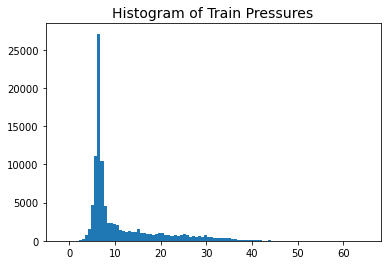

Max pressure = 64.82099173863948 Min pressure = -1.8957442945646408


In [1]:
import cupy, cudf, matplotlib.pyplot as plt
train_gf = cudf.read_csv('../input/ventilator-pressure-prediction/train.csv')

plt.title('Histogram of Train Pressures',size=14)
plt.hist(train_gf.sample(100_000).pressure.to_array(),bins=100)
plt.show()
print('Max pressure =',train_gf.pressure.max(), 'Min pressure =',train_gf.pressure.min())

In [2]:
all_pressure = cupy.sort( train_gf.pressure.unique().values )
print('The first 25 unique pressures...')
PRESSURE_MIN = all_pressure[0].item()
PRESSURE_MAX = all_pressure[-1].item()
all_pressure[:25]

The first 25 unique pressures...


array([-1.89574429, -1.82544215, -1.75514   , -1.68483786, -1.61453571,
       -1.54423357, -1.47393142, -1.40362928, -1.33332713, -1.26302499,
       -1.19272284, -1.12242069, -1.05211855, -0.9818164 , -0.91151426,
       -0.84121211, -0.77090997, -0.70060782, -0.63030568, -0.56000353,
       -0.48970139, -0.41939924, -0.34909709, -0.27879495, -0.2084928 ])

In [3]:
print('The differences between first 25 pressures...')
PRESSURE_STEP = ( all_pressure[1] - all_pressure[0] ).item()
all_pressure[1:26] - all_pressure[:25]

The differences between first 25 pressures...


array([0.07030215, 0.07030215, 0.07030215, 0.07030215, 0.07030215,
       0.07030215, 0.07030215, 0.07030215, 0.07030215, 0.07030215,
       0.07030215, 0.07030215, 0.07030215, 0.07030215, 0.07030215,
       0.07030215, 0.07030215, 0.07030215, 0.07030215, 0.07030215,
       0.07030215, 0.07030215, 0.07030215, 0.07030215, 0.07030215])

# Load Data

In [4]:
import numpy as np
import pandas as pd

import optuna

import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717

import tensorflow as tf, gc
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

DEBUG = False
TRAIN_MODEL = False

train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

if DEBUG:
    train = train[:80*1000]

# Engineer Features

In [5]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

train = add_features(train)
test = add_features(test)

targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['pressure', 'id', 'breath_id'], axis=1, inplace=True)
test = test.drop(['id', 'breath_id'], axis=1)

RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

# Infer Test Data

In [6]:
EPOCH = 300
BATCH_SIZE = 1024
NUM_FOLDS = 10

gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        K.clear_session()
        
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        checkpoint_filepath = f"folds{fold}.hdf5"
        if TRAIN_MODEL:
            model = keras.models.Sequential([
                keras.layers.Input(shape=train.shape[-2:]),
                keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
                keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
                keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
                keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
                keras.layers.Dense(128, activation='selu'),
                keras.layers.Dense(1),
            ])
            model.compile(optimizer="adam", loss="mae")

            lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
            es = EarlyStopping(monitor="val_loss", patience=60, verbose=1, mode="min", restore_best_weights=True)
            sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch',
                options=None
            )
            model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es, sv])
        else:
            model = keras.models.load_model('../input/finetune-of-tensorflow-bidirectional-lstm/'+checkpoint_filepath)
            
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE, verbose=2).squeeze().reshape(-1, 1).squeeze())
        
        del model, X_train, X_valid; gc.collect()

--------------- > Fold 1 < ---------------
50/50 - 38s
--------------- > Fold 2 < ---------------
50/50 - 32s
--------------- > Fold 3 < ---------------
50/50 - 32s
--------------- > Fold 4 < ---------------
50/50 - 32s
--------------- > Fold 5 < ---------------
50/50 - 32s
--------------- > Fold 6 < ---------------
50/50 - 32s
--------------- > Fold 7 < ---------------
50/50 - 32s
--------------- > Fold 8 < ---------------
50/50 - 32s
--------------- > Fold 9 < ---------------
50/50 - 32s
--------------- > Fold 10 < ---------------
50/50 - 32s


# Post Process with Median and Round

In [7]:
# ENSEMBLE FOLDS WITH MEAN
submission["pressure"] = sum(test_preds)/NUM_FOLDS
submission.to_csv('submission_mean_LB157.csv', index=False)

# ENSEMBLE FOLDS WITH MEDIAN
submission["pressure"] = np.median(np.vstack(test_preds),axis=0)
submission.to_csv('submission_median_LB155.csv', index=False)

# ENSEMBLE FOLDS WITH MEDIAN AND ROUND PREDICTIONS
submission["pressure"] =\
    np.round( (submission.pressure - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN
submission.pressure = np.clip(submission.pressure, PRESSURE_MIN, PRESSURE_MAX)
submission.to_csv('submission_median_round_LB153.csv', index=False)

# After PostProcess, Test Targets are Discrete - EDA

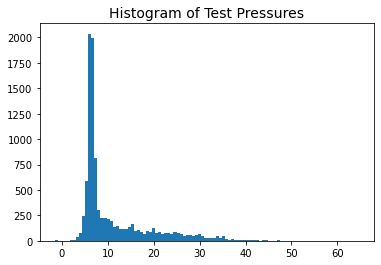

Max pressure = 64.82099173863328 Min pressure = -1.7551400036622216


In [8]:
plt.title('Histogram of Test Pressures',size=14)
plt.hist(submission.sample(10_000).pressure.values, bins=100)
plt.show()
print('Max pressure =',submission.pressure.max(), 'Min pressure =',submission.pressure.min())

In [9]:
all_pressure = np.sort( submission.pressure.unique() )
print('The differences between first 25 test pressures...')
all_pressure[1:26] - all_pressure[:25]

The differences between first 25 test pressures...


array([0.07030215, 0.07030215, 0.07030215, 0.07030215, 0.07030215,
       0.07030215, 0.07030215, 0.07030215, 0.07030215, 0.07030215,
       0.07030215, 0.07030215, 0.07030215, 0.07030215, 0.07030215,
       0.07030215, 0.07030215, 0.07030215, 0.07030215, 0.07030215,
       0.07030215, 0.07030215, 0.07030215, 0.07030215, 0.07030215])